# **Cars Dataset Analysis using ResNet34**

I selected the analysis of Cars dataset usin preset ResNet34 as the challenge problem. 

Importing the required libraries - 



In [1]:
import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import scipy.io as sio

First we will start by analysing the data. The cars dataset contains 16,185 images of 196 classes of cars. This data is split into 8,144 training and 8,041 testing images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data downloaded from the site 'https://s3.amazonaws.com/fast-ai-imageclas/stanford-cars.tgz' contains two folders with training and testing images and 'cars_annos.mat' with cars data. The cars data includes x1, x2, y1 and y2 coordinates of bounding box, class id and filename. 

We will load this data in a dataframe and analyse it.

In [3]:
data_dir ='/content/drive/My Drive/fellowship.ai'
annos_path = '/cars_annos.mat'

In [4]:
car_annos = sio.loadmat(data_dir + annos_path)

#Store the data from a container to a list and then in the dataframe
data = [[row.flat[0] for row in line] for line in car_annos['annotations'][0]]
columns = ['fname','bbox_x1','box_y1','bbox_x2','bbox_y2','classID','test']
car_annos_df = pd.DataFrame(data, columns=columns)

#Analyse the first and last 5 items in the dataframe
print(car_annos_df.head())
print(car_annos_df.tail())

                fname  bbox_x1  box_y1  bbox_x2  bbox_y2  classID  test
0  car_ims/000001.jpg      112       7      853      717        1     0
1  car_ims/000002.jpg       48      24      441      202        1     0
2  car_ims/000003.jpg        7       4      277      180        1     0
3  car_ims/000004.jpg       33      50      197      150        1     0
4  car_ims/000005.jpg        5       8       83       58        1     0
                    fname  bbox_x1  box_y1  bbox_x2  bbox_y2  classID  test
16180  car_ims/016181.jpg       38      36      375      234      196     1
16181  car_ims/016182.jpg       29      34      235      164      196     1
16182  car_ims/016183.jpg       25      32      587      359      196     1
16183  car_ims/016184.jpg       56      60      208      186      196     1
16184  car_ims/016185.jpg        1       1      200      131      196     1


The datafile provided contains 16,184 image datapoints which looks like this is both training and test data.
The first image in the training folder is an Audi TTS Coupe 2012 but images provided in the training folder are telling otherwise.

Since the data in provided in the container looks different from training and test images provided, we will load all the data from the main cars dataset website given: 'https://ai.stanford.edu/~jkrause/cars/car_dataset.html'

In [5]:
cars_train_path = '/cars_train_annos.mat'
cars_test_path = '/cars_test_annos_withlabels.mat'
classes_path = '/cars_meta.mat'

The data loaded from the main website contains three containers - data on training images, data on testing images and cars classes name data. 

We will load the training and test data to dataframes and also add the car class names based on class ID to the respective datasets.

In [8]:
def get_data(data_path, class_info):
  '''
  This function will load the data from containers to dataframe and also add a
  column 'class_names' to the original data based on classID.

  Input:
  data_path - Path directing to data container on images
  class_info - Path diecting to data container on car class names

  Output:
  car_annos_df - Dataframe of cars image data in the containers along with 
                 car class names assigned based on cars classID.
  '''

  car_annos = sio.loadmat(data_dir + data_path)
  car_meta = sio.loadmat(data_dir + class_info)

  #Store the class names temporarily in a dictionary
  nclasses = len(car_meta["class_names"][0])
  class_names = dict(zip(range(1,nclasses+1),[c[0] for c in car_meta["class_names"][0]]))

  #Store the data from a container to a list and then in the dataframe
  car_data = [[row.flat[0] for row in line] for line in car_annos['annotations'][0]]
  columns = ['bbox_x1','box_y1','bbox_x2','bbox_y2','classID','fname']
  car_annos_df = pd.DataFrame(car_data, columns=columns)

  #Add a colum to dataframe with class names based on classID
  car_annos_df = car_annos_df.assign(ClassName=car_annos_df.classID.map(dict(class_names)))
  columns = ['bbox_x1','box_y1','bbox_x2','bbox_y2','classID','fname','class_name']
  car_annos_df.columns=columns
  return car_annos_df


In [9]:
train_df = get_data(cars_train_path,classes_path)

#Analyse the first 5 items in the training dataframe
train_df.head()

,bbox_x1,box_y1,bbox_x2,bbox_y2,classID,fname,class_name
0,39,116,569,375,14,00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,3,00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,91,00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,134,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,106,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


In [11]:
test_df = get_data(cars_test_path,classes_path)

#Analyse the first 5 items in the test dataframe
test_df.head()

,bbox_x1,box_y1,bbox_x2,bbox_y2,classID,fname,class_name
0,30,52,246,147,181,00001.jpg,Suzuki Aerio Sedan 2007
1,100,19,576,203,103,00002.jpg,Ferrari 458 Italia Convertible 2012
2,51,105,968,659,145,00003.jpg,Jeep Patriot SUV 2012
3,67,84,581,407,187,00004.jpg,Toyota Camry Sedan 2012
4,140,151,593,339,185,00005.jpg,Tesla Model S Sedan 2012


Now since the data is loaded in proper format lets load the ResNet34 model. We will use fastai deep learning library.

Loading the correct version of PyTorch and fastai libraries

In [12]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4 MB 7.1 kB/s 
     |████████████████████████████████| 4.0 MB 35.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.


In [13]:
from fastai import *
from fastai.vision import *

Loading the images and transforming them for normalization. We will split the training images in training and validation sets. 



In [31]:
car_tfms = get_transforms()

#Create a dataframe with image name, classID and class name for training images
trn_df = pd.DataFrame(train_df[['fname', 'class_name', 'classID']],columns=['fname', 'class_name', 'classID'])

#Load training images and split into training & validation sets
src = (ImageList.from_df(trn_df, data_dir, folder='carstrain/1/', cols='fname')
                    .random_split_by_pct(valid_pct=0.2, seed=42)
                    .label_from_df(cols='class_name'))

train_data = (src.transform(car_tfms, size=224)
            .databunch()
            .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


Analysing the transformed images 

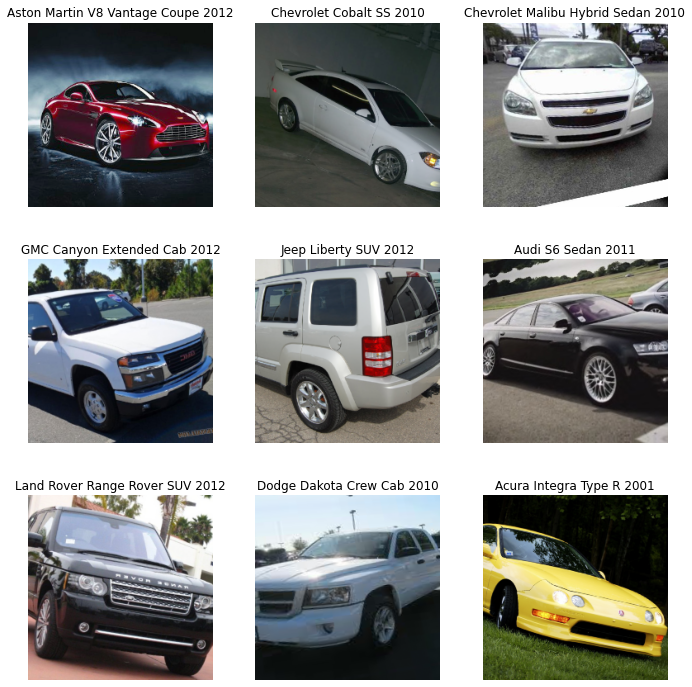

In [32]:
train_data.show_batch(rows=3, figsize=(10,10))

Loading the ResNet34 model

In [33]:
mdl = models.resnet34
train_data.batch_size = 64

Creating a model with current training data

In [34]:
 train1= create_cnn(train_data, mdl, metrics=[accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Finding an optimum learing rate for our model

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


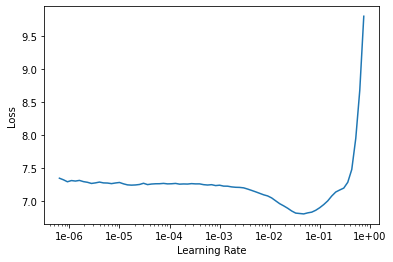

In [35]:
train1.lr_find()
train1.recorder.plot()

As we can see from the above graph, ideal learing rate is around 1e-02. We will use this learing rate for taining.

In [36]:
train1.fit_one_cycle(15,max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.958023,4.092636,0.121007,03:47
1,4.155767,2.777067,0.301597,03:43
2,3.391799,3.098922,0.278256,03:41
3,3.171475,3.201497,0.255528,03:40
4,2.724101,2.395274,0.387592,03:38
5,2.309881,2.143010,0.433047,03:46
6,2.066183,1.940208,0.489558,03:48
7,1.926021,1.889823,0.502457,03:47
8,1.656733,1.534660,0.591523,03:48
9,1.417064,1.362698,0.615479,03:48


After training for about 10 epochs on ResNet34 model with frozen initial layers, we have achieved a good accuracy. 

We will save this trained model as 'rn34_1'.

In [37]:
train1.save('rn34_1')

Now we will unfreeze the layers of ResNet34 to fine tune the weights.

In [38]:
train1.unfreeze()

For further training the model to finetune the weights, the learing rate will be lower than the initial one used. 

We will again find new optimum learing rate for training.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


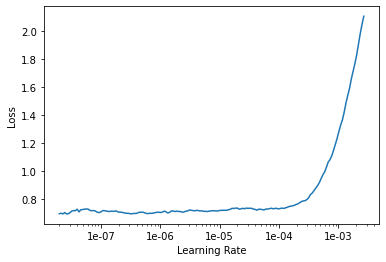

In [41]:
train1.lr_find(start_lr=1e-8, end_lr=1e-2,num_it=200)
train1.recorder.plot()

From the above graph, the ideal learning rate for further training is around 1e-07. We will use this learning rate for further training.

In [43]:
train1.load('rn34_1')
train1.unfreeze()

train1.fit_one_cycle(15,1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.716535,1.016487,0.722359,03:41
1,0.703925,1.020402,0.720516,03:38
2,0.707862,1.021427,0.718059,03:40
3,0.713369,1.015182,0.717445,03:38
4,0.732759,1.017416,0.721744,03:36
5,0.742715,1.016621,0.716216,03:36
6,0.725055,1.017359,0.719287,03:31
7,0.712296,1.015221,0.719902,03:32
8,0.710773,1.015762,0.719287,03:32
9,0.700143,1.023213,0.717445,03:33


After unfreezing and fine tuning the weight parameters, the accuracy of the validation set comes about 72%.

Lets save this as model as 'rn34_2'.

In [44]:
train1.save('rn34_2')

Now lets see what results we get if we unfreeze the layers from the begining and start learing on the training data.

Lets create a ResNet34 model and unfreeze all layers.

In [45]:
train3=create_cnn(train_data, mdl, metrics=[accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [46]:
train3.unfreeze()

Finding optimal learning rate.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


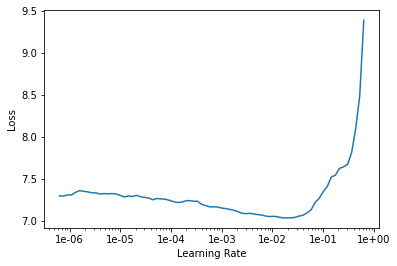

In [47]:
train3.lr_find()
train3.recorder.plot()

As seen from the above graph, the optimal learning rate is around 1e-02. We will now train the model using this learning rate.

In [48]:
train3.fit_one_cycle(15,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.249549,8.815243,0.012899,03:28
1,5.902668,23.220636,0.013514,03:29
2,6.173239,13.791155,0.003686,03:29
3,6.154198,18.449331,0.004914,03:31
4,5.688857,5.331534,0.014128,03:32
5,5.380248,5.239813,0.011671,03:27
6,5.200267,5.409633,0.015971,03:29
7,5.117691,5.138531,0.018428,03:29
8,5.032011,5.065331,0.023956,03:28
9,4.981705,5.491222,0.021499,03:25


As seen from the above table, the accuracy on validation set is very very low.

From the above exercise, we can see that training on pretrained model initially and then unfreezing the layers for further learning on training set gives better results.

This is because by doing this, we are taking advantage of some of the features learned by the model in previously. This significantly reduces training time and give better results.

Also, we currently do not have lot of training data images. So using unfrozen layers from the beginning will not give good accuracy since we need large data and computational power to learn all features.